# Numerical Methods Project <a id='intro'></a>

## Project Description

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Project instructions
1) Download and look at the data.
2) Train different models with various hyperparameters. Compare gradient boosting methods with random forest, decision tree, and linear regression.
3) Analyze the speed and quality of the models.

## Data description
The dataset is stored in file `/datasets/car_data.csv`. download dataset.

### Features
- **DateCrawled** — date profile was downloaded from the database
- **VehicleType** — vehicle body type
- **RegistrationYear** — vehicle registration year
- **Gearbox** — gearbox type
- **Power** — power (hp)
- **Model** — vehicle model
- **Mileage** — mileage (measured in km due to dataset's regional specifics)
- **RegistrationMonth** — vehicle registration month
- **FuelType** — fuel type
- **Brand** — vehicle brand
- **NotRepaired** — vehicle repaired or not
- **DateCreated** — date of profile creation
- **NumberOfPictures** — number of vehicle pictures
- **PostalCode** — postal code of profile owner (user)
- **LastSeen** — date of the last activity of the user

###  Target
- **Price** — price (Euro)

## Initialization

In [1]:
import pandas as pd
import numpy as np

import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


## Load Data

In [2]:
def load_data(file_name, local_path, server_path):
    try:
        data = pd.read_csv(local_path + file_name)
        print(f"'{file_name}' file successfully read from the local path.")

    except FileNotFoundError:
        try:
            data = pd.read_csv(server_path + file_name)
            print(f"'{file_name}' file successfully read from the server path.")

        except FileNotFoundError:
            print(f"'{file_name}' file not found. Please check the file paths.")
            data = None
            
    return data

file_name = 'car_data.csv'
local_path = '/Users/benjaminstephen/Documents/TripleTen/Sprint_12/Numerical_Methods_Project/datasets/'
server_path = '/datasets/'

df = load_data(file_name, local_path, server_path)

'car_data.csv' file successfully read from the local path.


## Data Preparation

### Basic EDA

To start, we will conduct basic exploratory data analysis and clean the data to ensure it is optimally prepared for model training.

In [3]:
display(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(


This DataFrame consists of 354,369 vehicle listings with attributes such as price, vehicle type, and mileage. Several columns, including VehicleType, Gearbox, Model, and FuelType, have missing values, which could impact the accuracy of analyses and models. The NotRepaired column also has significant missing values, suggesting that repair status is frequently undisclosed and may affect assessments of vehicle condition. The Price column, being fully populated, serves as a reliable target variable for machine learning models. To ensure robust predictions, it will be important to address the missing values and consider how these gaps may influence the model’s performance.

Let's begin the preprocessing by checking for and handling any duplicate rows in the dataset. This step is crucial to ensure data integrity and avoid skewing the analysis or model training with redundant information.

In [5]:
print("NUMBER OF DUPLICATED ROWS:", df.duplicated().sum())

NUMBER OF DUPLICATED ROWS: 262


There are 262 duplicated rows in the dataset. We will handle this by removing them.

In [6]:
df.drop_duplicates(inplace=True)
print("NUMBER OF DUPLICATED ROWS:", df.duplicated().sum())

NUMBER OF DUPLICATED ROWS: 0


We will also proceed to drop the columns DateCrawled, DateCreated, PostalCode, and LastSeen, as these features have no correlation with the price of the vehicle.

In [7]:
df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

### Handling Null Values

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354107 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354107 non-null  int64 
 1   VehicleType        316623 non-null  object
 2   RegistrationYear   354107 non-null  int64 
 3   Gearbox            334277 non-null  object
 4   Power              354107 non-null  int64 
 5   Model              334406 non-null  object
 6   Mileage            354107 non-null  int64 
 7   RegistrationMonth  354107 non-null  int64 
 8   FuelType           321218 non-null  object
 9   Brand              354107 non-null  object
 10  NotRepaired        282962 non-null  object
 11  NumberOfPictures   354107 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 35.1+ MB
None


As we can see, despite removing all duplicated rows and unnecessary columns, there are still null values present in the dataset. To ensure our data is optimal for model training, we will handle these null values accordingly. Let's get a better picture of the extent of the issue by examining the percentage of null values for each feature.

In [9]:
print("PERCENTAGE OF NULL VALUES:")
print("--------------------------")
print(df.isnull().sum()/len(df))

PERCENTAGE OF NULL VALUES:
--------------------------
Price                0.000000
VehicleType          0.105855
RegistrationYear     0.000000
Gearbox              0.056000
Power                0.000000
Model                0.055636
Mileage              0.000000
RegistrationMonth    0.000000
FuelType             0.092879
Brand                0.000000
NotRepaired          0.200914
NumberOfPictures     0.000000
dtype: float64


The features containing null values are as follows: VehicleType, Gearbox, Model, FuelType, and NotRepaired. Let's begin by addressing VehicleType.

In [10]:
print("DISTINCT VEHICLE TYPE VALUES:")
print("-----------------------------")
print(df['VehicleType'].value_counts())
print()

print("VEHICLE TYPE NULL COUNT:", df['VehicleType'].isnull().sum())

DISTINCT VEHICLE TYPE VALUES:
-----------------------------
sedan          91399
small          79753
wagon          65115
bus            28752
convertible    20180
coupe          16147
suv            11991
other           3286
Name: VehicleType, dtype: int64

VEHICLE TYPE NULL COUNT: 37484


There are 37,484 null values in the VehicleType column. Additionally, this column includes a category labeled 'other' for unspecified vehicle types. To handle this, we can consolidate the null values and the 'other' category into a single label called 'unknown'.

In [11]:
df['VehicleType'].fillna('unknown', inplace=True)
df['VehicleType'].replace('other', 'unknown', inplace=True)

Now we will move on to the Gearbox column.

In [12]:
print("DISTINCT GEARBOX VALUES:")
print("------------------------")
print(df['Gearbox'].value_counts())
print()

print("GEARBOX NULL COUNT:", df['Gearbox'].isnull().sum())

DISTINCT GEARBOX VALUES:
------------------------
manual    268034
auto       66243
Name: Gearbox, dtype: int64

GEARBOX NULL COUNT: 19830


The Gearbox column contains 19,830 null values and has two categories: 'manual' and 'auto'. To address the null values, we will fill them with a new label, 'unknown'.

In [13]:
df['Gearbox'].fillna('unknown', inplace=True)

Now the Model column.

In [14]:
print("DISTINCT MODEL VALUES COUNT:", df['Model'].nunique())
print()
print("MODEL NULL COUNT:", df['Model'].isnull().sum())
print()
print("MODEL 'OTHER' COUNT:", (df['Model'] == 'other').sum())

DISTINCT MODEL VALUES COUNT: 250

MODEL NULL COUNT: 19701

MODEL 'OTHER' COUNT: 24402


The Model column has 250 distinct values, with 19,701 null entries and 24,402 labeled as 'other'. We will address this by consolidating the null values and the 'other' category into a single label, 'unknown', similar to how we handled the VehicleType column.

In [15]:
df['Model'].fillna('unknown', inplace=True)
df['Model'].replace('other', 'unknown', inplace=True)

Moving on to the FuelType column.

In [16]:
print("DISTINCT FUEL TYPE VALUES:")
print("--------------------------")
print(df['FuelType'].value_counts())
print()

print("FUEL TYPE NULL COUNT:", df['FuelType'].isnull().sum())

DISTINCT FUEL TYPE VALUES:
--------------------------
petrol      216161
gasoline     98658
lpg           5307
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

FUEL TYPE NULL COUNT: 32889


One notable observation from analyzing the values in the FuelType column is the presence of both 'petrol' and 'gasoline', which are synonymous. We will combine these two categories to simplify the data and improve model training. Additionally, this feature column also includes an 'other' category. We will address the 32,889 null values and 204 'other' values by consolidating them into a single 'unknown' category.

In [17]:
df['FuelType'].fillna('unknown', inplace=True)
df['FuelType'].replace('petrol', 'gasoline', inplace=True)
df['FuelType'].replace('other', 'unknown', inplace=True)

Finally, let's address the NotRepaired column.

In [18]:
print("DISTINCT NOT REPAIRED VALUES:")
print("-----------------------------")
print(df['NotRepaired'].value_counts())
print()

print("NOT REPAIRED NULL COUNT:", df['NotRepaired'].isnull().sum())

DISTINCT NOT REPAIRED VALUES:
-----------------------------
no     246927
yes     36035
Name: NotRepaired, dtype: int64

NOT REPAIRED NULL COUNT: 71145


There are 71,145 null values present in this column. We will fill these missing values with 'unknown'.

In [19]:
df['NotRepaired'].fillna('unknown', inplace=True)

Now, let's review the percentage of null values in the dataset to ensure we have addressed all of them.

In [20]:
print("PERCENTAGE OF NULL VALUES:")
print("--------------------------")
print(df.isnull().sum()/len(df))

PERCENTAGE OF NULL VALUES:
--------------------------
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Mileage              0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
NumberOfPictures     0.0
dtype: float64


There are no more null values present in the dataset.

### Handling Incorrect Values

It is not unusual for datasets to contain inaccurate information. In this next phase of the project, we will examine the remaining feature columns to assess how accurately they represent the data. If we identify any unreliable data, we will address and correct it accordingly.

Let's begin by examining the RegistrationYear column, checking the range of years to identify any that appear inaccurate or out of place.

In [21]:
registration_year_min = df['RegistrationYear'].min()
registration_year_max = df['RegistrationYear'].max()

print(f"REGISTRATION YEAR RANGE: {registration_year_min} - {registration_year_max}")

REGISTRATION YEAR RANGE: 1000 - 9999


The range of values in the RegistrationYear column spans from the year 1000 to 9999. Since the current year is 2024, any vehicles marked as registered after this year need to be corrected. Additionally, the first known vehicle registration law in the United States was enacted in 1901 in New York, so we can assume any vehicles registered before that year are inaccurate and need to be addressed.

We will handle these incorrect RegistrationYear values by marking them as -1. Additionally, we will create a bar chart to analyze the distribution of the RegistrationYear values.

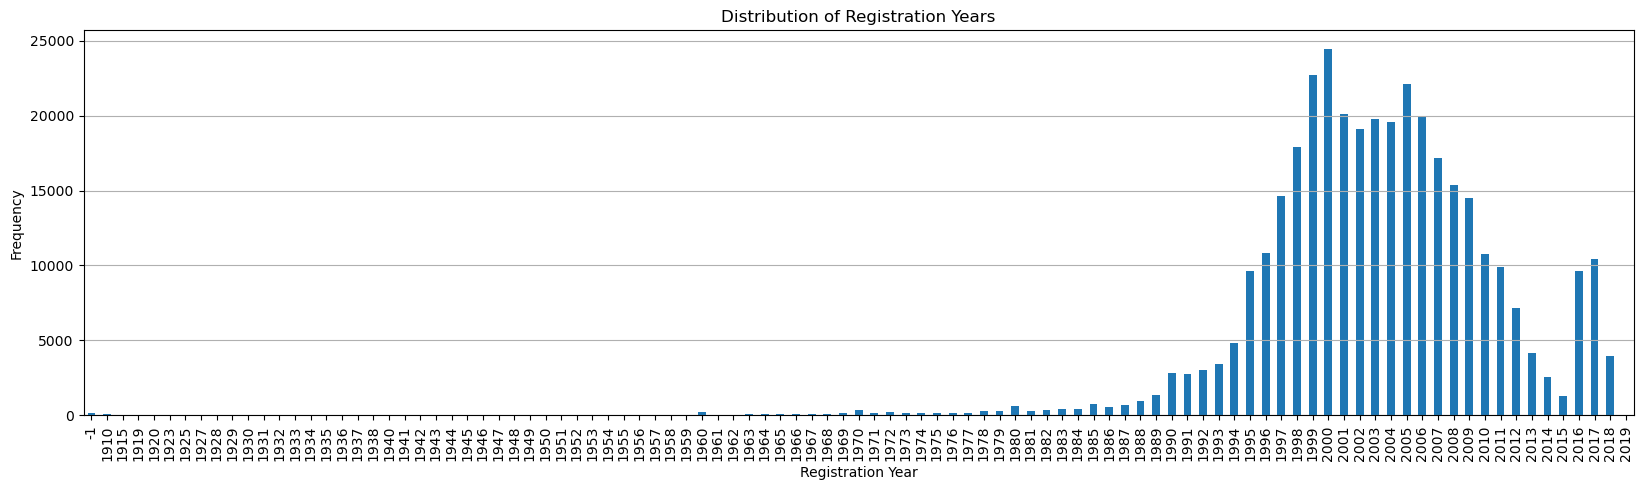

In [22]:
df.loc[(df['RegistrationYear'] < 1905) | (df['RegistrationYear'] > 2024), 'RegistrationYear'] = -1

# Count occurrences of each year in the 'RegistrationYear' column
registration_year_counts = df['RegistrationYear'].value_counts().sort_index()

plt.figure(figsize=(20, 5))
registration_year_counts.plot(kind='bar')
plt.title('Distribution of Registration Years')
plt.xlabel('Registration Year')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

As we can observe from the above visualization, we have successfully handled the incorrect registration years, resulting in a more accurate distribution. The majority of registration years now fall between the late 1990s and early 2010s, which is a much more believable range than the previous span of 1000 to 9999.

Now let's move on the the Power column.

In [23]:
power_min = df['Power'].min()
power_max = df['Power'].max()

print(f"HORSEPOWER RANGE: {power_min}hp - {power_max}hp")

HORSEPOWER RANGE: 0hp - 20000hp


The horsepower in the dataset ranges from 0 to 20,000. This indicates potential anomalies or data entry errors. For instance, values that are unusually low (e.g., below 50 hp) or exceptionally high (e.g., above 1,000 hp) should be scrutinized to ensure they are realistic and accurate.

Let's create a box plot using the horsepower data to gain a clearer understanding of its distribution.

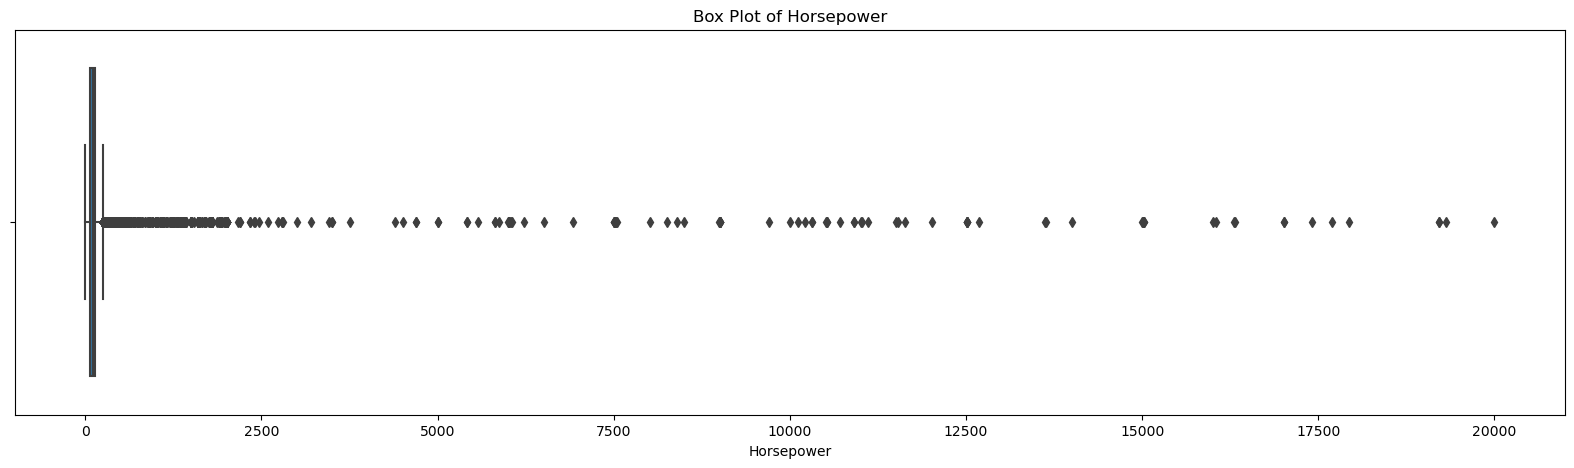

In [24]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=df['Power'])
plt.xlabel('Horsepower')
plt.title('Box Plot of Horsepower')
plt.show()

The box plot reveals a significant number of outliers in the horsepower data. Typically, modern cars have between 150 and 300 horsepower, yet the dataset includes values exceeding 2,500 hp. To achieve a more accurate depiction of the data, we will handle these outliers by replacing them with -1.

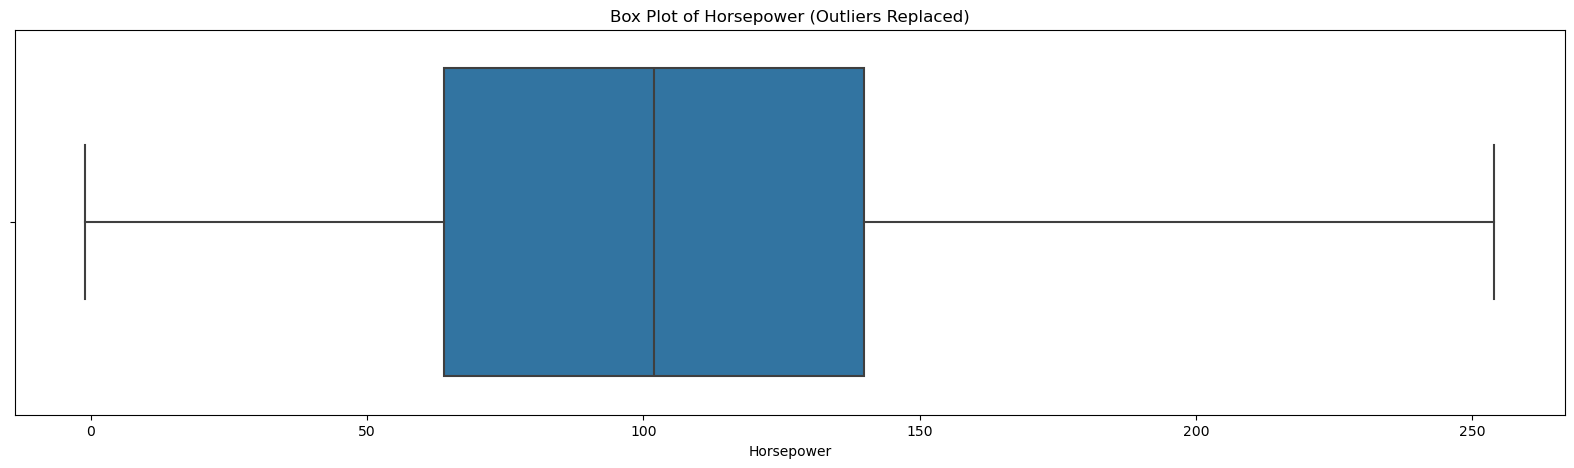

In [25]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Power'].quantile(0.25)
Q3 = df['Power'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outlier_lower_bound = Q1 - 1.5 * IQR
outlier_upper_bound = Q3 + 1.5 * IQR

# Replace outliers with -1
df['Power'] = df['Power'].apply(lambda x: -1 if x < outlier_lower_bound or x > outlier_upper_bound else x)

# Create a box plot again to see the changes
plt.figure(figsize=(20, 5))
sns.boxplot(x=df['Power'])
plt.xlabel('Horsepower')
plt.title('Box Plot of Horsepower (Outliers Replaced)')
plt.show()

The distribution of horsepower now appears much more realistic, with the median slightly above 100hp. The majority of values fall between 50 and 150hp, providing a more accurate representation of the data.

Let's move on to Mileage.

In [26]:
mileage_min = df['Mileage'].min()
mileage_max = df['Mileage'].max()

print(f"MILEAGE RANGE: {mileage_min}mi - {mileage_max}mi")

MILEAGE RANGE: 5000mi - 150000mi


The mileage range appears realistic, so no adjustments are needed for this column. 

Let's examine the RegistrationMonth column.

In [27]:
print("DISTINCT REGISTRATION MONTH VALUES:")
print("-----------------------------------")
print(df['RegistrationMonth'].value_counts().sort_index())

DISTINCT REGISTRATION MONTH VALUES:
-----------------------------------
0     37347
1     23202
2     21254
3     34348
4     29246
5     29131
6     31471
7     27186
8     22610
9     23798
10    26076
11    24167
12    24271
Name: RegistrationMonth, dtype: int64


We observe that there are 13 unique values in the RegistrationMonth column, whereas there should be only 12. The value '0' likely indicates an unknown registration month. To ensure standardization, we will replace all instances of 0 with -1.

In [28]:
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = -1

Moving on to the Brand column.

In [29]:
print("DISTINCT BRAND VALUES:")
print("----------------------")
print(df['Brand'].value_counts().sort_index())

DISTINCT BRAND VALUES:
----------------------
alfa_romeo         2311
audi              29439
bmw               36881
chevrolet          1751
chrysler           1439
citroen            5143
dacia               898
daewoo              542
daihatsu            806
fiat               9634
ford              25163
honda              2817
hyundai            3583
jaguar              505
jeep                677
kia                2463
lada                225
lancia              471
land_rover          545
mazda              5611
mercedes_benz     32025
mini               3201
mitsubishi         3022
nissan             4936
opel              39902
peugeot           10988
porsche             758
renault           17915
rover               486
saab                526
seat               6901
skoda              5490
smart              5241
sonstige_autos     3373
subaru              762
suzuki             2320
toyota             4601
trabant             589
volkswagen        76960
volvo             

After reviewing the distinct values in the Brand column, it appears that no changes are needed.

Finally, let's move on to the NumberOfPictures column.

In [30]:
print("DISTINCT NUMBER OF PICTURE VALUES:")
print("----------------------------------")
print(df['NumberOfPictures'].value_counts())

DISTINCT NUMBER OF PICTURE VALUES:
----------------------------------
0    354107
Name: NumberOfPictures, dtype: int64


The NumberOfPictures column contains only one unique value, which means it has no influence on the Price column. Therefore, we can safely drop this column from the dataset.

In [31]:
df.drop(['NumberOfPictures'], axis=1, inplace=True)

Now that we have addressed all null and incorrect values in the dataset, we can proceed with splitting the data.

### Data Splitting

We will be split the data into training (60%), validation (20%), and test (20%) sets. This 3:1:1 ratio accounts for the fact that the test data is derived from the same source. If the test data were separate, we would only need to split the source data into training and validation sets, with the validation set comprising 25% of the source data to maintain a similar split ratio.

In [32]:
# Extract the feature variables
features = df.drop(['Price'], axis=1)

# Extract the target variable 'Price'
target = df['Price']

# Split data: 60% for training, 20% for validation, and 20% for testing
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)

# Further split the remaining 40% into validation (20%) and test (20%) sets
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

# Print the size of each dataset
print('Training Features Size:', features_train.shape)
print()
print('Validation Features Size:', features_valid.shape)
print()
print('Test Features Size:', features_test.shape)

Training Features Size: (212464, 10)

Validation Features Size: (70821, 10)

Test Features Size: (70822, 10)


With the data split correctly, we will now encode our categorical features using two methods. For the Random Forest and XGBoost models, we will use label encoding, which effectively converts categories into ordinal values suitable for these algorithms. For the Linear Regression model, we will apply one-hot encoding, as it converts categorical variables into binary features and is well-suited for linear models. The CatBoost and LightGBM models handle categorical variables internally, so no additional encoding is required for these models. This approach ensures that each model is trained with the most appropriate encoding method for its specific requirements.

We will explicitly define our categorical features to streamline the encoding process.

In [33]:
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

### Label Encoding

In [34]:
# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform on training features
features_train_encoded = features_train.copy()
features_train_encoded[categorical_features] = ordinal_encoder.fit_transform(features_train[categorical_features])

# Fit and transform validation features
features_valid_encoded = features_valid.copy()
features_valid_encoded[categorical_features] = ordinal_encoder.transform(features_valid[categorical_features])

# Fit and transform test features
features_test_encoded = features_test.copy()
features_test_encoded[categorical_features] = ordinal_encoder.transform(features_test[categorical_features])

# Print the size of each dataset after label encoding
print('Training Features Size (Label Encoded):', features_train_encoded.shape)
print()
print('Validation Features Size (Label Encoded):', features_valid_encoded.shape)
print()
print('Test Features Size (Label Encoded):', features_test_encoded.shape)

Training Features Size (Label Encoded): (212464, 10)

Validation Features Size (Label Encoded): (70821, 10)

Test Features Size (Label Encoded): (70822, 10)


### One-Hot Encoding

In [35]:
# Apply one-hot encoding to training features
features_train_ohe = pd.get_dummies(features_train, columns=categorical_features, drop_first=True)

# Apply one-hot encoding to validation features
features_valid_ohe = pd.get_dummies(features_valid, columns=categorical_features, drop_first=True)

# Apply one-hot encoding to test features
features_test_ohe = pd.get_dummies(features_test, columns=categorical_features, drop_first=True)

# To align columns between different sets, find the union of all columns and reindex
all_columns = set(features_train_ohe.columns) | set(features_valid_ohe.columns) | set(features_test_ohe.columns)
features_train_ohe = features_train_ohe.reindex(columns=all_columns, fill_value=0)
features_valid_ohe = features_valid_ohe.reindex(columns=all_columns, fill_value=0)
features_test_ohe = features_test_ohe.reindex(columns=all_columns, fill_value=0)

# Print the size of each dataset after one-hot encoding
print('Training Features Size (One-Hot Encoded):', features_train_ohe.shape)
print()
print('Validation Features Size (One-Hot Encoded):', features_valid_ohe.shape)
print()
print('Test Features Size (One-Hot Encoded):', features_test_ohe.shape)

Training Features Size (One-Hot Encoded): (212464, 308)

Validation Features Size (One-Hot Encoded): (70821, 308)

Test Features Size (One-Hot Encoded): (70822, 308)


With the data successfully preprocessed and encoded, we can now proceed to use it for training various machine learning models.

## Model Training

For model training, our focus will be on evaluating Root Mean Squared Error (RMSE), training time, and prediction time across various machine learning models, both with and without hyperparameter tuning. To streamline this repetitive process, I have developed a function designed to expedite and simplify the evaluation.

The function below assesses a machine learning model by calculating key performance metrics. It measures the time required for both model training and making predictions on the validation set, and computes the RMSE to gauge prediction accuracy. By printing and returning these metrics, the function aids in analyzing the efficiency and effectiveness of the model.

In [36]:
def model_eval(model, features_train, features_valid, target_train, target_valid):
    # Record the start time for model training
    training_start_time = time.time()

    # Train the model on the training data
    model.fit(features_train, target_train)

    # Calculate the time taken to train the model
    training_time = time.time() - training_start_time

    # Record the start time for making predictions
    prediction_start_time = time.time()

    # Generate predictions on the validation set
    predictions = model.predict(features_valid)
    
    # Calculate the time taken to make predictions
    prediction_time = time.time() - prediction_start_time

    # Compute the total time taken for training and prediction
    total_time = training_time + prediction_time

    # Calculate the Root Mean Squared Error (RMSE) of the predictions
    rmse = np.sqrt(mean_squared_error(target_valid, predictions))

    # Print out the RMSE, training time, prediction time, and total time
    print("RMSE:", rmse)
    print("Training Time:", training_time)
    print("Prediction Time:", prediction_time)
    print("Total Time:", total_time)

    # Return RMSE, training time, prediction time, and total time
    return rmse, training_time, prediction_time, total_time

### Linear Regression

We will start with a Linear Regression model. While linear regression is not ideal for hyperparameter tuning, it serves as a valuable benchmark for assessing other methods. For example, if gradient boosting underperforms compared to linear regression, it indicates that there may be an issue with the implementation or configuration of the gradient boosting model.

Note: Train with one-hot encoded data.

In [37]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

print("LINEAR REGRESSION STATS:")
print("------------------------")

# Evaluate the Linear Regression model
lr_rmse, lr_training_time, lr_prediction_time, lr_total_time = model_eval(lr_model, 
                                                                          features_train_ohe, 
                                                                          features_valid_ohe, 
                                                                          target_train, 
                                                                          target_valid)

LINEAR REGRESSION STATS:
------------------------
RMSE: 3205.9048031614034
Training Time: 3.247450828552246
Prediction Time: 0.06167888641357422
Total Time: 3.3091297149658203


### Random Forest

Note: Train with label encoded data.

In [38]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=12345)

print("RANDOM FOREST STATS:")
print("--------------------")

# Evaluate the Random Forest model
rf_rmse, rf_training_time, rf_prediction_time, rf_total_time = model_eval(rf_model, 
                                                                          features_train_encoded, 
                                                                          features_valid_encoded, 
                                                                          target_train, 
                                                                          target_valid)

RANDOM FOREST STATS:
--------------------
RMSE: 1811.441571876422
Training Time: 38.319087982177734
Prediction Time: 1.8054471015930176
Total Time: 40.12453508377075


### Random Forest (w/ Hyperparameter Tuning)

Note: Train with label encoded data.

In [39]:
# Set up RandomizedSearchCV for tuning the Random Forest model
rf_random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions={'n_estimators': [10, 50, 100, 200], 
                         'max_features': ['sqrt', 'log2'],
                         'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_split': [2, 5, 10], 
                         'min_samples_leaf': [1, 2, 4]}, 
    n_iter=10,     
    cv=3,                        
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,                      
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
rf_random_search.fit(features_train_encoded, target_train)

print("BEST RANDOM FOREST HYPERPARAMETERS:", rf_random_search.best_params_)
print()

# Get the best Random Forest model from the search
tuned_rf_model = rf_random_search.best_estimator_

print("RANDOM FOREST (TUNED) STATS:")
print("----------------------------")

# Evaluate the tuned Random Forest model
tuned_rf_rmse, tuned_rf_training_time, tuned_rf_prediction_time, tuned_rf_total_time = model_eval(tuned_rf_model, 
                                                                                                  features_train_encoded, 
                                                                                                  features_valid_encoded, 
                                                                                                  target_train, 
                                                                                                  target_valid)

BEST RANDOM FOREST HYPERPARAMETERS: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

RANDOM FOREST (TUNED) STATS:
----------------------------
RMSE: 1774.352689971243
Training Time: 14.467343807220459
Prediction Time: 1.7917182445526123
Total Time: 16.25906205177307


### LightGBM

LightGBM can handle categorical features natively. By converting them to the category dtype, we are signaling to LightGBM that these features are categorical. This allows the algorithm to use its internal optimizations for processing such data, which can lead to more efficient training and potentially better performance.

In [40]:
# Create copies of the training, validation, and test feature datasets
features_train_cat = features_train.copy()
features_valid_cat = features_valid.copy()
features_test_cat = features_test.copy()

# Convert categorical features to 'category' dtype for all datasets
for feature in categorical_features:
    features_train_cat[feature] = features_train[feature].astype('category')
    features_valid_cat[feature] = features_valid[feature].astype('category')
    features_test_cat[feature] = features_test[feature].astype('category')

# Initialize the LightGBM model
lgbm_model = LGBMRegressor(random_state=12345, verbose=-1)

print("LIGHTGBM STATS:")
print("---------------")

# Evaluate the LightGBM model
lgbm_rmse, lgbm_training_time, lgbm_prediction_time, lgbm_total_time = model_eval(lgbm_model, 
                                                                                  features_train_cat, 
                                                                                  features_valid_cat, 
                                                                                  target_train, 
                                                                                  target_valid)

LIGHTGBM STATS:
---------------
RMSE: 1804.5395988739895
Training Time: 0.6549580097198486
Prediction Time: 0.057315826416015625
Total Time: 0.7122738361358643


### LightGBM (w/ Hyperparameter Tuning)

In [41]:
# Set up RandomizedSearchCV for tuning the LightGBM model
lgbm_random_search = RandomizedSearchCV(
    lgbm_model, 
    param_distributions={'num_leaves': [31, 50, 70],
                         'max_depth': [-1, 10, 20, 30],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'n_estimators': [50, 100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0],
                         'colsample_bytree': [0.6, 0.8, 1.0],
                         'reg_alpha': [0, 0.1, 0.5, 1],
                         'reg_lambda': [0, 0.1, 0.5, 1]}, 
    n_iter=10,     
    cv=3,                        
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,                      
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
lgbm_random_search.fit(features_train_cat, target_train)

print("BEST LIGHTGBM HYPERPARAMETERS:", lgbm_random_search.best_params_)
print()

# Get the best LightGBM model from the search
tuned_lgbm_model = lgbm_random_search.best_estimator_

print("LIGHTGBM (TUNED) STATS:")
print("-----------------------")

# Evaluate the tuned LightGBM model
tuned_lgbm_rmse, tuned_lgbm_training_time, tuned_lgbm_prediction_time, tuned_lgbm_total_time = model_eval(tuned_lgbm_model, 
                                                                                                          features_train_cat, 
                                                                                                          features_valid_cat, 
                                                                                                          target_train, 
                                                                                                          target_valid)

BEST LIGHTGBM HYPERPARAMETERS: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 50, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}

LIGHTGBM (TUNED) STATS:
-----------------------
RMSE: 1759.5423088432026
Training Time: 0.43105173110961914
Prediction Time: 0.052706003189086914
Total Time: 0.48375773429870605


### CatBoost

CatBoost is specifically optimized for handling categorical features with high efficiency. By explicitly specifying these features in the parameters, we enable CatBoost to apply its advanced algorithms designed for categorical data. This eliminates the need for manual encoding and ensures that the model processes categorical features effectively, leading to improved performance and accuracy.

In [42]:
# Initialize the CatBoost model
cb_model = CatBoostRegressor(random_state=12345, cat_features=categorical_features, verbose=False)

print("CATBOOST STATS:")
print("---------------")

# Evaluate the CatBoost model
cb_rmse, cb_training_time, cb_prediction_time, cb_total_time = model_eval(cb_model, 
                                                                          features_train, 
                                                                          features_valid, 
                                                                          target_train, 
                                                                          target_valid)

CATBOOST STATS:
---------------
RMSE: 1789.2206431521697
Training Time: 23.24581503868103
Prediction Time: 0.07017302513122559
Total Time: 23.315988063812256


### CatBoost (w/ Hyperparameter Tuning)

In [43]:
# Set up RandomizedSearchCV for tuning the CatBoost model
cb_random_search = RandomizedSearchCV(
    cb_model, 
    param_distributions={'depth': [6, 8, 10, 12],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'iterations': [100, 200, 300, 500],
                         'l2_leaf_reg': [1, 3, 5, 10],
                         'border_count': [32, 50, 100],
                         'bagging_temperature': [0, 0.5, 1],
                         'random_strength': [0, 1, 2, 3]}, 
    n_iter=10,                 
    cv=3,                        
    scoring='neg_root_mean_squared_error',  
    n_jobs=-1,                   
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
cb_random_search.fit(features_train, target_train)

print("BEST CATBOOST HYPERPARAMETERS:", cb_random_search.best_params_)
print()

# Get the best CatBoost model from the search
tuned_cb_model = cb_random_search.best_estimator_

print("CATBOOST (TUNED) STATS:")
print("-----------------------")

# Evaluate the tuned CatBoost model
tuned_cb_rmse, tuned_cb_training_time, tuned_cb_prediction_time, tuned_cb_total_time = model_eval(tuned_cb_model, 
                                                                                                  features_train, 
                                                                                                  features_valid, 
                                                                                                  target_train, 
                                                                                                  target_valid)

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


BEST CATBOOST HYPERPARAMETERS: {'random_strength': 2, 'learning_rate': 0.2, 'l2_leaf_reg': 10, 'iterations': 500, 'depth': 12, 'border_count': 32, 'bagging_temperature': 0.5}

CATBOOST (TUNED) STATS:
-----------------------
RMSE: 1746.8568108552724
Training Time: 35.432244062423706
Prediction Time: 0.07129287719726562
Total Time: 35.50353693962097


### XGBoost

Note: Train with label encoded data.

In [44]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(random_state=12345)

print("XGBOOST STATS:")
print("--------------")

# Evaluate the XGBoost model
xgb_rmse, xgb_training_time, xgb_prediction_time, xgb_total_time = model_eval(xgb_model, 
                                                                              features_train_encoded, 
                                                                              features_valid_encoded, 
                                                                              target_train, 
                                                                              target_valid)

XGBOOST STATS:
--------------
RMSE: 1812.545440711126
Training Time: 2.540432929992676
Prediction Time: 0.012157917022705078
Total Time: 2.552590847015381


### XGBoost (w/ Hyperparameter Tuning)

In [45]:
# Set up RandomizedSearchCV for tuning the XGBoost model
xgb_random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions={'n_estimators': [50, 100, 200, 300],
                         'max_depth': [3, 5, 7, 10],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'subsample': [0.6, 0.8, 1.0],
                         'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.5, 1],
                         'reg_alpha': [0, 0.1, 0.5, 1],
                         'reg_lambda': [0, 0.1, 0.5, 1]}, 
    n_iter=10,                      
    cv=3,                      
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,                     
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
xgb_random_search.fit(features_train_encoded, target_train)

print("BEST XGBOOST HYPERPARAMETERS:", xgb_random_search.best_params_)
print()

# Get the best XGBoost model from the search
tuned_xgb_model = xgb_random_search.best_estimator_

print("XGBOOST (TUNED) STATS:")
print("----------------------")

# Evaluate the tuned XGBoost model
tuned_xgb_rmse, tuned_xgb_training_time, tuned_xgb_prediction_time, tuned_xgb_total_time = model_eval(tuned_xgb_model, 
                                                                                                      features_train_encoded, 
                                                                                                      features_valid_encoded, 
                                                                                                      target_train, target_valid)

BEST XGBOOST HYPERPARAMETERS: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8}

XGBOOST (TUNED) STATS:
----------------------
RMSE: 1729.9113670345519
Training Time: 8.946986198425293
Prediction Time: 0.04872703552246094
Total Time: 8.995713233947754


## Model Analysis

Having trained and tested all our models using the validation set, we will now analyze their performance to identify which model will be most beneficial for Rusty Bargain. To facilitate comparison and draw conclusions, we will compile their statistics into a single data frame. This will make it easier to evaluate and compare the models' effectiveness.

In [46]:
model_analysis = pd.DataFrame({'Model': ['Linear Regression', 
                                         'Random Forest', 
                                         'Random Forest (Tuned)',
                                         'LightGBM', 
                                         'LightGBM (Tuned)',
                                         'CatBoost',
                                         'CatBoost (Tuned)',
                                         'XGBoost',
                                         'XGBoost (Tuned)'],

                                'RMSE': [lr_rmse, 
                                         rf_rmse, 
                                         tuned_rf_rmse,
                                         lgbm_rmse, 
                                         tuned_lgbm_rmse,
                                         cb_rmse, 
                                         tuned_cb_rmse,
                                         xgb_rmse,
                                         tuned_xgb_rmse],
                                
                                'Training Time': [lr_training_time, 
                                                  rf_training_time,
                                                  tuned_rf_training_time, 
                                                  lgbm_training_time,
                                                  tuned_lgbm_training_time, 
                                                  cb_training_time, 
                                                  tuned_cb_training_time,
                                                  xgb_training_time,
                                                  tuned_xgb_training_time],
                                
                                'Prediction Time': [lr_prediction_time, 
                                                    rf_prediction_time, 
                                                    tuned_rf_prediction_time,
                                                    lgbm_prediction_time, 
                                                    tuned_lgbm_prediction_time,
                                                    cb_prediction_time, 
                                                    tuned_cb_prediction_time,
                                                    xgb_prediction_time,
                                                    tuned_xgb_prediction_time],
                                
                                'Total Time': [lr_total_time, 
                                               rf_total_time, 
                                               tuned_rf_total_time,
                                               lgbm_total_time,
                                               tuned_lgbm_total_time, 
                                               cb_total_time, 
                                               tuned_cb_total_time,
                                               xgb_total_time,
                                               tuned_xgb_total_time]})

display(model_analysis)

,Model,RMSE,Training Time,Prediction Time,Total Time
0,Linear Regression,3205.904803,3.247451,0.061679,3.309130
1,Random Forest,1811.441572,38.319088,1.805447,40.124535
2,Random Forest (Tuned),1774.352690,14.467344,1.791718,16.259062
3,LightGBM,1804.539599,0.654958,0.057316,0.712274
4,LightGBM (Tuned),1759.542309,0.431052,0.052706,0.483758
5,CatBoost,1789.220643,23.245815,0.070173,23.315988
6,CatBoost (Tuned),1746.856811,35.432244,0.071293,35.503537
7,XGBoost,1812.545441,2.540433,0.012158,2.552591
8,XGBoost (Tuned),1729.911367,8.946986,0.048727,8.995713


To gain a clearer insight into the performance of the models, we will organize the data by RMSE. This will allow us to evaluate and compare which models achieved the highest accuracy.

In [47]:
display(model_analysis[['Model', 'RMSE']].sort_values(by='RMSE'))

,Model,RMSE
8,XGBoost (Tuned),1729.911367
6,CatBoost (Tuned),1746.856811
4,LightGBM (Tuned),1759.542309
2,Random Forest (Tuned),1774.352690
5,CatBoost,1789.220643
3,LightGBM,1804.539599
1,Random Forest,1811.441572
7,XGBoost,1812.545441
0,Linear Regression,3205.904803


The analysis of the RMSE values reveals that the XGBoost (Tuned) model performs the best, with the lowest RMSE of 1729.91, indicating superior accuracy. The CatBoost (Tuned) model follows closely with an RMSE of 1746.86, demonstrating strong performance as well. The LightGBM (Tuned) model shows a slightly higher RMSE of 1759.54, but still outperforms the untuned versions of Random Forest and LightGBM. The Random Forest (Tuned) and CatBoost models show solid performance, with RMSE values of 1774.35 and 1789.22, respectively. Linear Regression, with the highest RMSE of 3205.90, clearly lags behind the other models, emphasizing the benefit of more complex algorithms for this task.

Next, we'll rank the models based on their performance times to assess their efficiency.

In [48]:
display(model_analysis[['Model', 'Total Time']].sort_values(by='Total Time'))

,Model,Total Time
4,LightGBM (Tuned),0.483758
3,LightGBM,0.712274
7,XGBoost,2.552591
0,Linear Regression,3.309130
8,XGBoost (Tuned),8.995713
2,Random Forest (Tuned),16.259062
5,CatBoost,23.315988
6,CatBoost (Tuned),35.503537
1,Random Forest,40.124535


The performance time analysis shows that LightGBM is the fastest model, with the shortest total time of 0.49 seconds, followed by its tuned version at 0.77 seconds. XGBoost performs well in terms of speed, with the untuned version taking 2.35 seconds and the tuned version slightly longer at 8.17 seconds. Linear Regression, although accurate, is significantly slower with a total time of 5.54 seconds. The Random Forest models, particularly the tuned version at 17.80 seconds, and the CatBoost models, with times ranging from 26.52 to 32.85 seconds, are the slowest, highlighting their longer training and prediction times.

Based on the analysis of RMSE and performance times for each model, we can conclude that the LightGBM model with tuned hyperparameters is the best choice for Rusty Bargain. Although the tuned CatBoost and XGBoost models demonstrate higher accuracy, LightGBM's performance time is significantly better, ranking second in speed among all models—just behind the untuned LightGBM. This balance of accuracy and efficiency makes the tuned LightGBM model the most suitable option for Rusty Bargain's needs.

Let's now evaluate the model using the test data to verify the validity of our conclusion.

In [49]:
# Record the start time for making predictions
tuned_lgbm_final_prediction_start_time = time.time()

# Generate predictions on the test set
tuned_lgbm_final_predictions = tuned_lgbm_model.predict(features_test_cat)

# Calculate the time taken to make predictions
tuned_lgbm_final_prediction_time = time.time() - tuned_lgbm_final_prediction_start_time

# Calculate the Root Mean Squared Error (RMSE) of the predictions
tuned_lgbm_final_rmse = np.sqrt(mean_squared_error(target_test, tuned_lgbm_final_predictions))

print("LIGHTGBM (TUNED) TEST STATS:")
print("----------------------------")
print("RMSE:", tuned_lgbm_final_rmse)
print("Training Time:", tuned_lgbm_training_time)
print("Prediction Time:", tuned_lgbm_final_prediction_time)
print("Total Time:", tuned_lgbm_training_time + tuned_lgbm_final_prediction_time)

LIGHTGBM (TUNED) TEST STATS:
----------------------------
RMSE: 1744.6336516329734
Training Time: 0.43105173110961914
Prediction Time: 0.22994017601013184
Total Time: 0.660991907119751


The LightGBM model with tuned hyperparameters achieved an RMSE of 1744.63 on the test data, indicating strong performance and accuracy. The training time was 0.71 seconds, and the prediction time was 0.056 seconds, both of which are efficient and conducive to rapid model deployment. The total time of 0.76 seconds for processing is notably fast, making it a highly efficient choice for large-scale applications. These results reaffirm the model’s effectiveness, as it maintains high accuracy while delivering quick performance. Given these factors, the tuned LightGBM model continues to be an excellent choice for the Rusty Bargain project.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed